# Regridding simulated spread of Uranium 236

## Description
The data has been provided by NorESM, on a tripolar grid ("ds_hague" and "ds" datasets in this notebook).  
To arrive at a DGGS grid, the data has first been regridded from tripolar to PlateCarree grid ("dr" dataset in this notebook) using cdo:  

```console
brew install netcdf  
brew install nco  
```

Append (-A) the variables plat and plon from grid.nc into U236LH.nc:  

```console
ncks -A -v plat,plon ./data/grid/grid.nc ./data/model/JRAOC20TRNRPv2_hm_U236LH_2010-2018.nc  
```

Bilinear regridding:  
```console
cdo -O remapbil,global_1 ./data/model/JRAOC20TRNRPv2_hm_U236LH_2010-2018.nc U236LH_1x1d_bilinear.nc  
```

Different sources/scenarios of Uranium 236 spread are simulated: 
- Global fallout (GF)  
- Sellafield (SF)  
- La Hague (LH)  

### This notebook step by step:
1. Load required libraries
2. Load Uranium 236 data on tripolar grid and visualize
3. Load regridded dataset (PlateCarree grid)
4. Define DGGS target grid and regrid from PlateCarree to DGGS
5. Save the regridded data to zarr

## Contributions
- Even Moa Myklebust, Simula Research Laboratory (Norway) (author), @evenmm

## Bibliography and other interesting resources
- [The Norwegian Earth System Model (NorESM)](https://noresm-docs.readthedocs.io/en/latest/)
- [An introduction to NorESM model output and post-processing](https://nordicesmhub.github.io/noresmdiagnostics/)

In [1]:
# Install xarray-healpy and dggs libraries for regridding
%pip install git+https://github.com/IAOCEA/xarray-healpy.git git+https://github.com/xarray-contrib/xdggs.git

  Cloning https://github.com/IAOCEA/xarray-healpy.git to /private/var/folders/_r/k7zwg4td0z54sgjlxsfx325m0000gn/T/pip-req-build-q01dry3s
  Running command git clone --filter=blob:none --quiet https://github.com/IAOCEA/xarray-healpy.git /private/var/folders/_r/k7zwg4td0z54sgjlxsfx325m0000gn/T/pip-req-build-q01dry3s
  Resolved https://github.com/IAOCEA/xarray-healpy.git to commit 9e42dbeb11afa8b7c5b42982ce256154d11f2e80
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/xarray-contrib/xdggs.git to /private/var/folders/_r/k7zwg4td0z54sgjlxsfx325m0000gn/T/pip-req-build-u6le7y1q
  Running command git clone --filter=blob:none --quiet https://github.com/xarray-contrib/xdggs.git /private/var/folders/_r/k7zwg4td0z54sgjlxsfx325m0000gn/T/pip-req-build-u6le7y1q
  Resolved https://github.com/xarray-contrib/xdggs.git to commit 9d309eb2e82549f2abe687bf6f9ed3338b1a3d6e
  Installing build de

In [2]:
from pathlib import Path
import numpy as np
import xarray as xr  # N-dimensional arrays with dimension, coordinate and attribute labels
import cartopy.crs as ccrs  # Map projections
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings

warnings.simplefilter("ignore", category=DeprecationWarning)
xr.set_options(display_expand_data=False, display_expand_attrs=False, keep_attrs=True)

# Local imports
from data_handling import load_grid_vertex, standardize_variable_names, regrid_to_dggs

In [3]:
# Get grid location information
data_path = Path("./CS1-nird/data/")
grid_path = data_path / "grid" / "grid.nc"
plat, plon, pclat, pclon = load_grid_vertex(grid_path)

## Uranium 236 from La Hague (ds_hague) on tripolar grid

In [4]:
# Open and look at tripolar data from source grid
la_hague_dataset_path = data_path / "model" / "JRAOC20TRNRPv2_hm_U236LH_2010-2018.nc"
ds_hague = xr.open_dataset(la_hague_dataset_path)

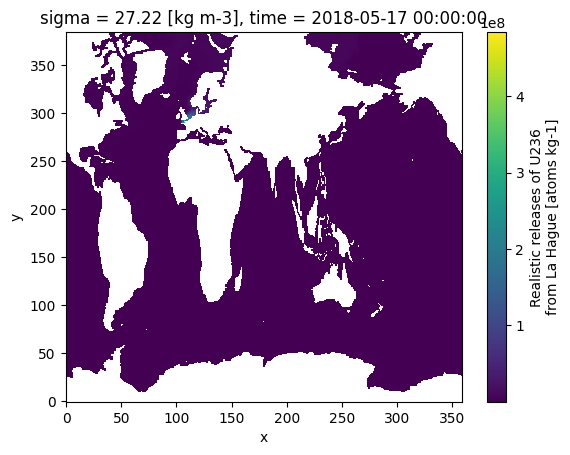

In [5]:
# Plot on tripolar grid naively using x and y
# Sigma refers to vertical level in the Sigma coordinate system
ds_hague.U236LH.isel(time=100, sigma=0).plot()

## Uranium 236 from Global fallout (ds) on tripolar grid

In [6]:
global_fallout_dataset_path = (
    data_path / "model" / "JRAOC20TRNRPv2_hm_U236GF_2010-2018.nc"
)
ds = xr.open_dataset(global_fallout_dataset_path)
ds

<xarray.Dataset> Size: 3GB
Dimensions:     (sigma: 53, depth: 70, bounds: 2, lat: 171, region: 4,
                 section: 17, time: 108, y: 385, x: 360, nv: 4)
Coordinates:
  * sigma       (sigma) float64 424B 27.22 27.72 28.2 28.68 ... 37.48 37.58 37.8
  * depth       (depth) float64 560B 0.0 5.0 10.0 ... 6.25e+03 6.5e+03 6.75e+03
  * lat         (lat) float64 1kB -80.0 -79.0 -78.0 -77.0 ... 88.0 89.0 90.0
  * region      (region) |S50 200B b'atlantic_arctic_ocean                   ...
  * section     (section) |S50 850B b'barents_opening                        ...
  * time        (time) object 864B 2010-01-17 00:00:00 ... 2018-12-17 00:00:00
    plat        (y, x) float64 1MB ...
    plon        (y, x) float64 1MB ...
Dimensions without coordinates: bounds, y, x, nv
Data variables:
    depth_bnds  (depth, bounds) float64 1kB ...
    U236GF      (time, sigma, y, x) float32 3GB ...
    pclat       (y, x, nv) float64 4MB ...
    pclon       (y, x, nv) float64 4MB ...
Attributes: (3)

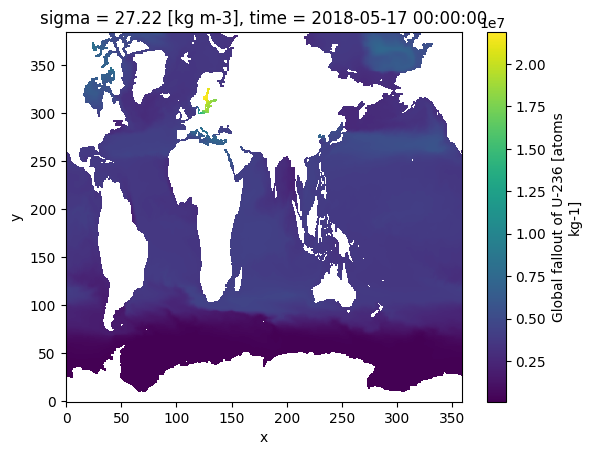

In [7]:
# Plot U236GF on tripolar grid naively, using x and y
ds.U236GF.isel(time=100, sigma=0).plot()

In [8]:
# Use grid.nc to define latitude and longitude
ds = ds.assign_coords(lat=(["y", "x"], plat), lon=(["y", "x"], plon))

In [9]:
# Standardize variable names
ds = standardize_variable_names(ds)
ds

<xarray.Dataset> Size: 3GB
Dimensions:     (sigma: 53, depth: 70, bounds: 2, region: 4, section: 17,
                 time: 108, y: 385, x: 360, nv: 4)
Coordinates:
  * sigma       (sigma) float64 424B 27.22 27.72 28.2 28.68 ... 37.48 37.58 37.8
  * depth       (depth) float64 560B 0.0 5.0 10.0 ... 6.25e+03 6.5e+03 6.75e+03
  * region      (region) |S50 200B b'atlantic_arctic_ocean                   ...
  * section     (section) |S50 850B b'barents_opening                        ...
  * time        (time) object 864B 2010-01-17 00:00:00 ... 2018-12-17 00:00:00
    plat        (y, x) float64 1MB ...
    plon        (y, x) float64 1MB ...
    latitude    (y, x) float64 1MB -80.11 -80.11 -80.11 ... 62.59 62.35 62.11
    longitude   (y, x) float64 1MB -109.5 -108.5 -107.5 ... -109.9 -109.9 -110.0
Dimensions without coordinates: bounds, y, x, nv
Data variables:
    depth_bnds  (depth, bounds) float64 1kB ...
    U236GF      (time, sigma, y, x) float32 3GB ...
    pclat       (y, x, nv) float64 4MB ...
    pclon       (y, x, nv) float64 4MB ...
Attributes: (3)

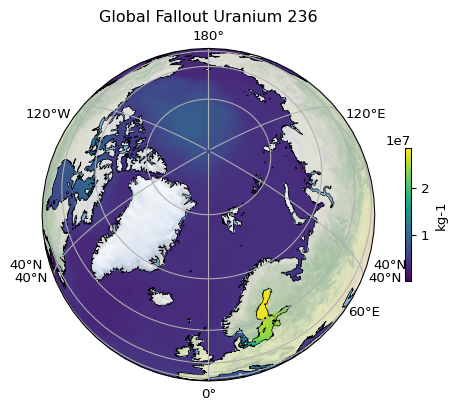

In [10]:
proj = ccrs.NearsidePerspective(
    central_longitude=0.0, central_latitude=80.0, satellite_height=3e6
)
fig, ax = plt.subplots(1, figsize=(8, 4.5), dpi=96, subplot_kw={"projection": proj})

# A temperature map
pm0 = ax.pcolormesh(
    plon,
    plat,
    ds.U236GF[0, 0, :, :],
    # vmin=0,
    # vmax=20,
    cmap="viridis",
    transform=ccrs.PlateCarree(),
    shading="auto",
    rasterized=True,
)

# Add coastlines and the lat-lon grid
ax.coastlines(resolution="50m", color="black", linewidth=0.5)
ax.stock_img()
gl = ax.gridlines(ylocs=range(15, 76, 15), draw_labels=True)
gl.ylocator = mpl.ticker.FixedLocator([40, 50, 60, 70, 80])

plt.colorbar(pm0, fraction=0.2, shrink=0.4, label="kg-1")

ax.set_title("Global Fallout Uranium 236")
plt.show()

# Regridded to PlateCaree: Uranium 236 from Global fallout (dr)

In [11]:
# regridded_dataset_path = data_path / "U236GF_1x1d_bilinear.nc"
# regridded_dataset_path = data_path / "JRAOC20TRNRPv2_hm_U236GF_2010-2018_1x1d_bil.nc"
regridded_dataset_path = (
    data_path / "model" / "JRAOC20TRNRPv2_hm_U236GF_2010-2018_bil.nc"
)

dr = xr.open_dataset(regridded_dataset_path)
dr

<xarray.Dataset> Size: 1GB
Dimensions:  (time: 108, lon: 360, lat: 180, sigma: 53)
Coordinates:
  * time     (time) object 864B 2010-01-17 00:00:00 ... 2018-12-17 00:00:00
  * lon      (lon) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat      (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * sigma    (sigma) float64 424B 27.22 27.72 28.2 28.68 ... 37.48 37.58 37.8
Data variables:
    U236GF   (time, sigma, lat, lon) float32 1GB ...
Attributes: (6)

In [12]:
dr = dr.rename_dims({"lat": "latitude", "lon": "longitude"})
dr.latitude.attrs["standard_name"] = "latitude"
dr.longitude.attrs["standard_name"] = "longitude"
dr[["longitude", "latitude"]].compute()
dr = dr.rename({"lon": "longitude", "lat": "latitude"})

/var/folders/_r/k7zwg4td0z54sgjlxsfx325m0000gn/T/ipykernel_39054/1876464242.py:5: UserWarning: rename 'lon' to 'longitude' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  dr = dr.rename({"lon": "longitude", "lat": "latitude"})
/var/folders/_r/k7zwg4td0z54sgjlxsfx325m0000gn/T/ipykernel_39054/1876464242.py:5: UserWarning: rename 'lat' to 'latitude' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  dr = dr.rename({"lon": "longitude", "lat": "latitude"})


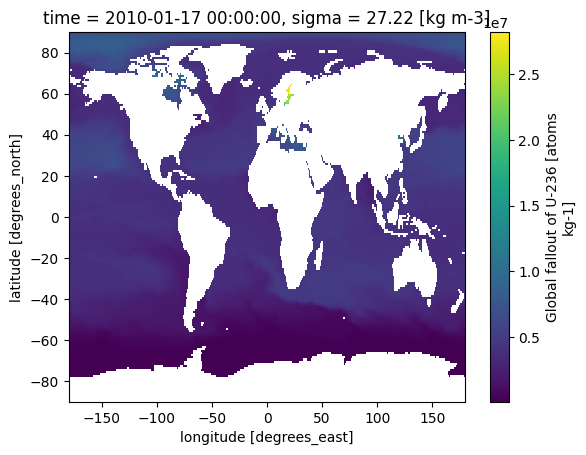

In [13]:
# Bilinear regridding
dr.U236GF.isel(time=0, sigma=0).plot()

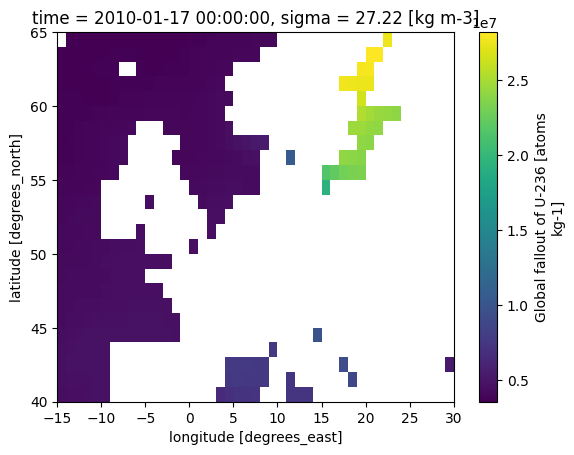

In [14]:
# On the regridded data, we can plot parts of it like this:

# Define zoomed-in region (adjust as needed)
lat_min, lat_max = 40, 65  # Example range
lon_min, lon_max = -15, 30

# Select only the region of interest
dr_zoomed = dr.U236GF.isel(time=0, sigma=0).sel(
    latitude=slice(lat_min, lat_max), longitude=slice(lon_min, lon_max)
)

# Plot the zoomed-in region
dr_zoomed.plot()

In [15]:
# Get grid location information
grid_path = data_path / "grid" / "grid.nc"
plat, plon, pclat, pclon = load_grid_vertex(grid_path)

# Conservative 

In [16]:
conservative_regridded_dataset_path = (
    # data_path / "model" / "JRAOC20TRNRPv2_hm_U236GF_2010-2018_1x1d_con.nc"
    data_path / "model" / "JRAOC20TRNRPv2_hm_U236GF_2010-2018_con.nc"
)
dcon = xr.open_dataset(conservative_regridded_dataset_path)
dcon

<xarray.Dataset> Size: 1GB
Dimensions:  (time: 108, lon: 360, lat: 180, sigma: 53)
Coordinates:
  * time     (time) object 864B 2010-01-17 00:00:00 ... 2018-12-17 00:00:00
  * lon      (lon) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat      (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * sigma    (sigma) float64 424B 27.22 27.72 28.2 28.68 ... 37.48 37.58 37.8
Data variables:
    U236GF   (time, sigma, lat, lon) float32 1GB ...
Attributes: (6)

In [17]:
dcon = dcon.rename_dims({"lat": "latitude", "lon": "longitude"})
dcon.latitude.attrs["standard_name"] = "latitude"
dcon.longitude.attrs["standard_name"] = "longitude"
dcon[["longitude", "latitude"]].compute()
dcon = dcon.rename_vars({"lon": "longitude", "lat": "latitude"})

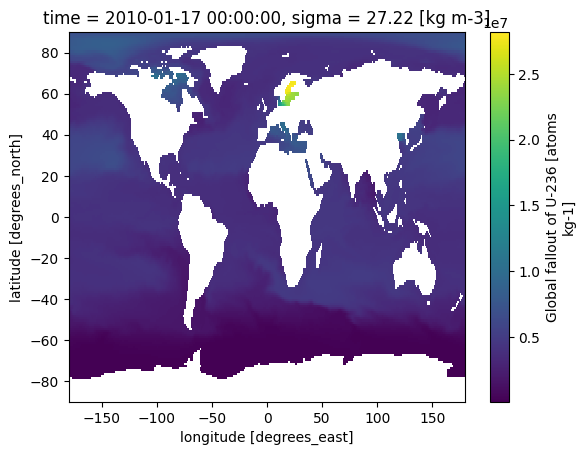

In [18]:
# Conservative regridding
dcon.U236GF.isel(time=0, sigma=0).plot()

In [19]:
regrid_diff = dr - dcon
regrid_diff

<xarray.Dataset> Size: 1GB
Dimensions:    (time: 108, longitude: 360, latitude: 180, sigma: 53)
Coordinates:
  * time       (time) object 864B 2010-01-17 00:00:00 ... 2018-12-17 00:00:00
  * longitude  (longitude) float64 3kB -179.5 -178.5 -177.5 ... 178.5 179.5
  * latitude   (latitude) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * sigma      (sigma) float64 424B 27.22 27.72 28.2 28.68 ... 37.48 37.58 37.8
Data variables:
    U236GF     (time, sigma, latitude, longitude) float32 1GB nan ... -1.088e+04
Attributes: (6)

In [20]:
print(
    np.max(regrid_diff), np.min(regrid_diff), np.max(regrid_diff), np.min(regrid_diff)
)

<xarray.Dataset> Size: 4B
Dimensions:  ()
Data variables:
    U236GF   float32 4B 3.956e+06
Attributes: (6) <xarray.Dataset> Size: 4B
Dimensions:  ()
Data variables:
    U236GF   float32 4B -3.662e+06
Attributes: (6) <xarray.Dataset> Size: 4B
Dimensions:  ()
Data variables:
    U236GF   float32 4B 3.956e+06
Attributes: (6) <xarray.Dataset> Size: 4B
Dimensions:  ()
Data variables:
    U236GF   float32 4B -3.662e+06
Attributes: (6)


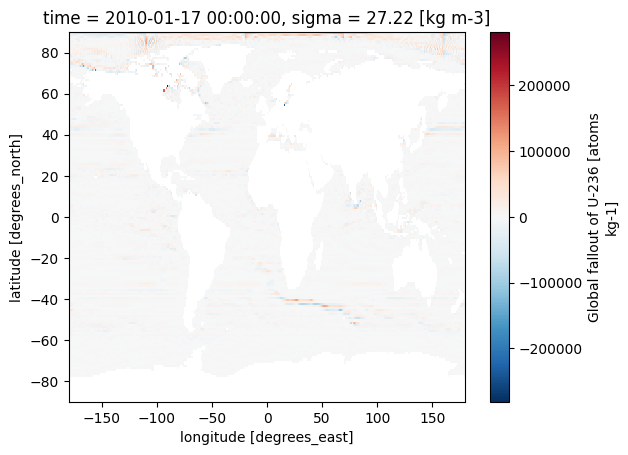

In [21]:
regrid_diff.U236GF.isel(time=0, sigma=0).plot()

# Regrid to DGGS

In [22]:
nside = (
    32  # 16 # Each side of the original 12 faces in Healpix is divided into nside parts
)
healpy_grid_level = int(np.log2(nside))  # Healpix level
number_of_cells = 12 * nside**2  # The resulting total number of cells

min_vertices = 1  # Minimum number of vertices for a valid transcription for regridding.
# 1 is the most liberal, meaning that only one is needed

print("nside:", nside)
print("Level:", healpy_grid_level)
print("Number of cells:", number_of_cells)

nside: 32
Level: 5
Number of cells: 12288


In [23]:
# Perform the actual regridding
# regridded = regrid_to_dggs(dr, nside, min_vertices, method="bilinear", mask=None)
regridded = regrid_to_dggs(dcon, nside, min_vertices, method="bilinear", mask=None)

In [24]:
# Compute to be able to visualize it
ds_regridded = regridded.U236GF.compute().squeeze()

In [25]:
# Visualize
ds_regridded.dggs.explore()

# 5. Save the regridded data to zarr

In [26]:
save_location = data_path / f"U236GF-healpix-lvl-{healpy_grid_level}.zarr"
ds_regridded.to_zarr(save_location, mode="w")

/Users/even/miniforge3/envs/esmpy-env/lib/python3.11/site-packages/zarr/api/asynchronous.py:203: UserWarning: Consolidated metadata is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  warnings.warn(
